In [1]:
import io
import warnings

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

# show figures inline
%matplotlib inline

# ignore all warning (NOT recommended)
warnings.filterwarnings("ignore")

## Embedding
- Transforming words to a multi-dimensional vector.

**Example: IMDB movie review dataset** ([official webpage](http://ai.stanford.edu/~amaas/data/sentiment/)) 

In [3]:
# get the dataset
imdb = tfds.load('imdb_reviews', as_supervised=True, shuffle_files=False)

# split into training and testing
ds_train, ds_test = imdb['train'], imdb['test']

# extract the data
def extract(dataset):
    all_x, all_y = [], []
    for x, y in dataset:
        all_x.append(str(x.numpy()))
        all_y.append(y.numpy())
    return np.array(all_x), np.array(all_y)

# training dataset
x_train, y_train = extract(ds_train)
# testing dataset
x_test, y_test = extract(ds_test)

**Tokenize and pad**

In [4]:
VOCAB_SIZE = 10_000
EMBED_DIMS = 16
MAX_LENGTH = 120
TRUNC_TYPE = 'post'

In [5]:
# initiate a tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')

# update the vocabulary on training texts
tokenizer.fit_on_texts(x_train)

print('# words in the vocabulary:', len(tokenizer.word_index))

# words in the vocabulary: 86539


In [6]:
# get sequences
sequences = tokenizer.texts_to_sequences(x_train)

# padding
padded_x_train = pad_sequences(
    sequences, padding='post', maxlen=MAX_LENGTH, truncating=TRUNC_TYPE
    )

print('padded shape:', padded_x_train.shape)

padded shape: (25000, 120)


In [7]:
# pad testing sequence
test_sequences = tokenizer.texts_to_sequences(x_test)
padded_x_test = pad_sequences(
    test_sequences, padding='post', maxlen=MAX_LENGTH, truncating=TRUNC_TYPE
    )

**Model**
- Build a neural network model to learn the embeddings.
- The `Embedding` layer learns to vectorized the words.
- Instead of `Flatten` layer, it is common to use `GlobalAveragePooling1D`. It is faster.

In [8]:
# input layer
input_tensor = Input(shape=MAX_LENGTH)

# embedding layer
x = Embedding(
    input_dim=VOCAB_SIZE, 
    output_dim=EMBED_DIMS,
    input_length=MAX_LENGTH
)(input_tensor)

# flatten by using global average-pooling in 1D
x = GlobalAveragePooling1D()(x)
# alternatively, we can use: x = Flatten()(x)

# fully-connected layers
x = Dense(6, activation='relu')(x)

# output layer with 'sigmoid' activation function
output_tensor = Dense(1, activation='sigmoid')(x)

# model
model = tf.keras.Model(input_tensor, output_tensor)

# compile with 'sparse_categorical_crossentropy' loss
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['acc']
)

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


**Train**

In [9]:
# train the model
hist = model.fit(
    padded_x_train, y_train,
    batch_size=250,
    validation_data=(padded_x_test, y_test),
    epochs=10,
    verbose=1,
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 2s 82us/sample - loss: 0.6841 - acc: 0.6592 - val_loss: 0.6679 - val_acc: 0.7166
Epoch 2/10
25000/25000 [==============================] - 1s 48us/sample - loss: 0.6276 - acc: 0.7576 - val_loss: 0.5900 - val_acc: 0.7652
Epoch 3/10
25000/25000 [==============================] - 1s 49us/sample - loss: 0.5250 - acc: 0.8088 - val_loss: 0.4980 - val_acc: 0.8013
Epoch 4/10
25000/25000 [==============================] - 1s 55us/sample - loss: 0.4325 - acc: 0.8380 - val_loss: 0.4378 - val_acc: 0.8156
Epoch 5/10
25000/25000 [==============================] - 1s 49us/sample - loss: 0.3721 - acc: 0.8570 - val_loss: 0.4049 - val_acc: 0.8255
Epoch 6/10
25000/25000 [==============================] - 1s 39us/sample - loss: 0.3326 - acc: 0.8705 - val_loss: 0.3897 - val_acc: 0.8280
Epoch 7/10
25000/25000 [==============================] - 1s 40us/sample - loss: 0.3038 - acc: 0.8808 - val_loss: 0.

## **Show training graphs**

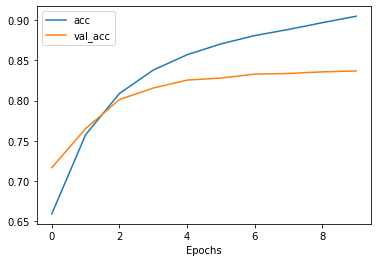

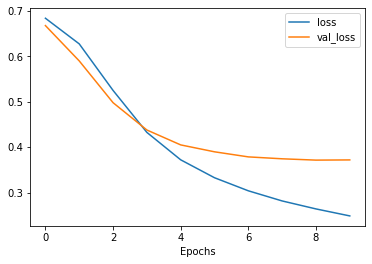

In [10]:
def plot_graphs(history, metrics):
    plt.figure()
    for metric in metrics:
        plt.plot(history.history[metric], label=metric)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
  
plot_graphs(hist, ["acc", "val_acc"])
plot_graphs(hist, ["loss", "val_loss"])

**See the embedding weights**

In [11]:
# shape of the weights win the embedding layers
weights = model.layers[1].get_weights()[0]

print(weights.shape)

(10000, 16)


**Save vector and metadata**

In [12]:
DIR_LOGS = '00-logs'

reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

out_v = io.open(DIR_LOGS + '/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open(DIR_LOGS + '/meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, VOCAB_SIZE):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

**Visualize**
- Go to [tensorflor embedding projector](http://projector.tensorflow.org/).
- Upload the `vecs.tsv` and `meta.tsv` files and see the embeddings.